# Contrast curves

In [1]:
cd /home

/home


In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from core.metrics import inject_companion, get_rings, get_throughput, get_aperture_photometry
from core.data import load_data

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
datapath ='./data/HCI/'
predlogs = './logs/HCI/'

cube, psfs, rot_angles = load_data(datapath)

params_table = pd.read_csv(os.path.join(predlogs, 'prediction.csv'))

row = params_table.iloc[0]
pixel = 0.01225
cube = cube[0] # single wavelength
psfs = psfs[0] # single wavelength

print(psfs.shape, cube.shape)

[INFO] channels:  [0 1]
New shape: (2, 63, 63)
`Size` is even (while input frame size is odd). Setting `size` to 31 pixels
(2, 90, 201, 201)
New shape: (2, 63, 63)
`Size` is even (while input frame size is odd). Setting `size` to 31 pixels
(2, 63, 63) (90, 201, 201)


## step 1: Cleaning cube dataset

In [4]:
cube_center = cube.shape[-1]/2

radius = np.sqrt((-cube_center)**2+(row['optimal_y']-cube_center)**2)

injected = inject_companion(row['optimal_x'], 
                            row['optimal_y'], 
                            row['optimal_flux'],
                            cube=np.zeros_like(cube),
                            psf=psfs[0],
                            rot_angles=rot_angles)

Branch 1:
	(X,Y)=(90.47, 86.85) at 0.20 arcsec (16.24 pxs from center)


In [5]:
clean_cube = cube - injected # subtract the planet

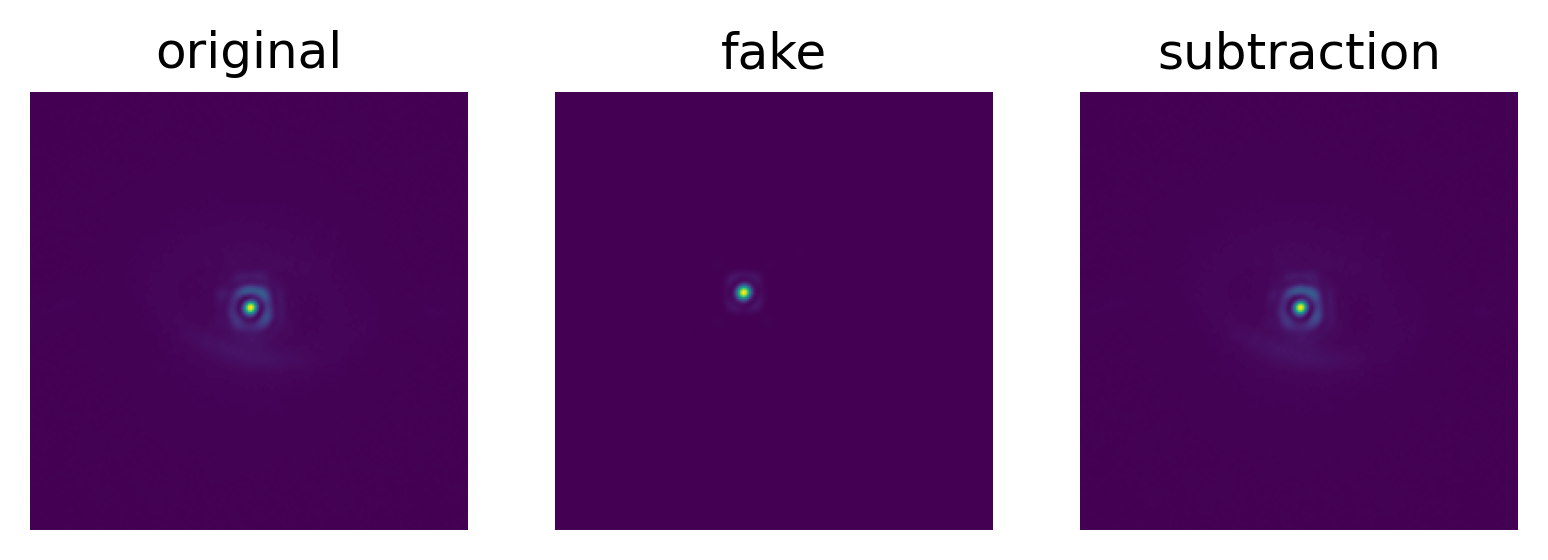

In [6]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, dpi=300)
axes[0].imshow(cube[0], origin='lower')
axes[1].imshow(injected[0], origin='lower')
axes[2].imshow(clean_cube[0], origin='lower')

for ax, title in zip(axes, ['original', 'fake', 'subtraction']):
    ax.axis('off')
#     ax.set_xlim(row['optimal_x']-40, row['optimal_x']+40)
#     ax.set_ylim(row['optimal_y']-20, row['optimal_y']+50)
    ax.set_title(title)

## step 2: Draw rings FWHM-diameter apertures

In [20]:
nframes, width, height = cube.shape
max_boundary = width * 0.5
num_rings =  20

regions = get_rings(row['optimal_x'], row['optimal_y'], 
                    fhwm=row['fwhm_mean'],
                    cube=clean_cube, 
                    rot_angles=rot_angles,
                    num_rings=num_rings)

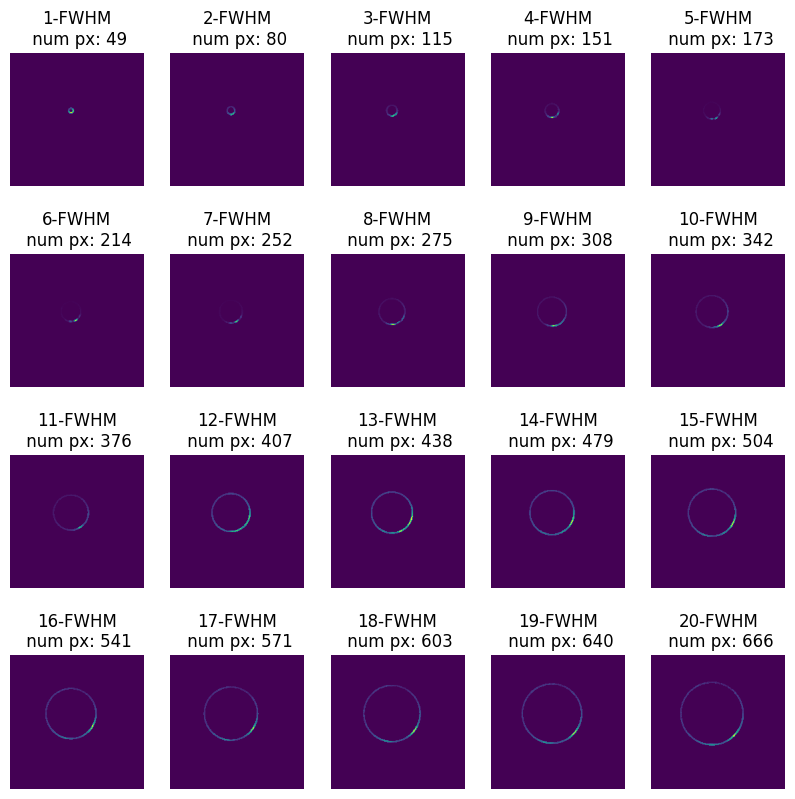

In [45]:
fig, axes = plt.subplots(4, 5, figsize=(10,10))
axes = axes.flatten()
for i in range(1, 21):
    N = np.sum(regions[i-1][0]!=0.)
    axes[i-1].imshow(regions[i-1][0])
    axes[i-1].axis('off')
    axes[i-1].set_title('{}-FWHM\n num px: {}'.format(i, N))

## step 3: Find the fraction of resolution element whose sum exceeds the detection threshold

In [106]:
ap_phot = get_aperture_photometry(cube, row['optimal_x'], row['optimal_y'], 
                               rot_angles=rot_angles,
                               fwhm=row['fwhm_mean'])

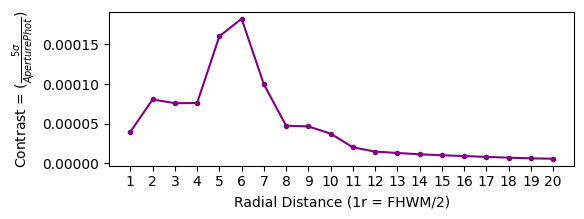

In [126]:
x_range = range(1, 21, 1)
plt.figure(figsize=(6, 2))
plt.plot(x_range, contrast, marker='.', color='purple')
plt.ylabel(r'Contrast = ($\frac{5\sigma}{AperturePhot}$)')
plt.xlabel('Radial Distance (1r = FHWM/2)')
plt.xticks(x_range)
plt.show()

## step 4: Estimate the algorithm throughput 

In [55]:
get_throughput(row['optimal_x'], row['optimal_y'], cube)